# AT training in Multilayer Perceptron with Numpy

This notebook is based on the Deep Learning course from the Master Datascience Paris Saclay. Materials of the course can be found [here](https://github.com/m2dsupsdlclass/lectures-labs). 

### Goal of the notebook:
   * Implement a real gradient descent and a multilayer perceptron using `Numpy`.
   
### Dataset used:
   * The MNIST dataset ([Kaggle link](https://www.kaggle.com/c/digit-recognizer/overview)).

In [127]:
# Display figure in the notebook
%matplotlib inline

In [128]:
# Load packages
import random

# from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras import initializers, optimizers
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils import to_categorical

In [129]:
# Define some functions
def plot_mnist(data, index, label=None):
    """Plot one image from the mnist dataset."""
    fig = plt.figure(figsize=(3, 3))
    if type(data) == pd.DataFrame:
        plt.imshow(np.asarray(data.iloc[index, 1:]).reshape((HEIGHT, WIDTH)),
                   cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.title(f"Image label: {data.loc[index, 'label']}")
    else:
        plt.imshow(data[index].reshape((HEIGHT, WIDTH)),
                   cmap=plt.cm.gray_r,
                   interpolation='nearest')
        plt.title(f"Image label: {label}")
    
    plt.axis('off')
    return fig

def plot_prediction(X, y, model, sample_idx=0, classes=range(10), model_from=None):
    """Plot the prediction for a given image."""
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))


    # Reshape the input data to 2D array for inverse_transform
    X_sample = X[sample_idx].reshape(1, -1)
    # Plot the image
    X_inverse_transformed = scaler.inverse_transform(X_sample)
    ax0.imshow(X_inverse_transformed.reshape(HEIGHT, WIDTH), 
               cmap=plt.cm.gray_r,
               interpolation='nearest')
    # # Plot the image
    # ax0.imshow(scaler.inverse_transform(X[sample_idx]).reshape(HEIGHT, WIDTH), 
    #            cmap=plt.cm.gray_r,
    #            interpolation='nearest')
    ax0.axis('off')
    ax0.set_title(f"True image label: {y[sample_idx]}");

    # Plot the predictions
    ax1.bar(classes, one_hot(len(classes), y[sample_idx]), label='true')
    if model_from == 'keras':
        ax1.bar(classes, model.predict_proba(X[sample_idx, np.newaxis]).squeeze(), 
            label='prediction', color="red")
        prediction = model.predict_classes(X[sample_idx, np.newaxis])[0]
    else:
        ax1.bar(classes, model.forward(X[sample_idx]).squeeze(), 
            label='prediction', color="red")
        prediction = model.predict(X[sample_idx])
    ax1.set_xticks(classes)
    ax1.set_title(f'Output probabilities (prediction: {prediction})')
    ax1.set_xlabel('Digit class')
    ax1.legend()
    
def plot_history(history):
    """Plot the history of the training of a neural network."""
    fig = plt.figure(figsize=(10, 5))
    
    ax1 = fig.add_subplot(121)
    ax1.set(title='Model loss', xlabel='Epochs', ylabel='Loss')
    
    ax2 = fig.add_subplot(122)
    ax2.set(title='Model accuracy', xlabel='Epochs', ylabel='Accuracy')
    
    if len(history) == 2:
        ax1.plot(history['loss'])
        ax2.plot(history['acc'])
    else:
        for lr in history:
            ax1.plot(history[lr]['loss'], label=lr)
            ax2.plot(history[lr]['acc'], label=lr)
        ax1.legend(title='Learning rate')
        ax2.legend(title='Learning rate')
        
    return fig

In [130]:
# Load the data(inaccurate physical input)
digits_train = pd.read_csv('/Users/lixingmin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/project2_code/digit-recognizer/train.csv')
digits_test = pd.read_csv('/Users/lixingmin/Library/Mobile Documents/com~apple~CloudDocs/Desktop/project2_code/digit-recognizer/test.csv')


In [131]:
print(f"Train dataset: {digits_train.shape[0]} images")
print(f"Shape of the dataset: {digits_train.shape}")

Train dataset: 42000 images
Shape of the dataset: (42000, 785)


In [132]:
# Define some global parameters
HEIGHT = 28 # Height of an image
WIDTH = 28 # Width of an image
PIXEL_NUMBER = 784 # Number of pixel in an image
PIXEL_VALUE = 255 # Maximum pixel value in an image

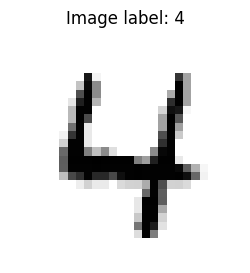

In [133]:
# Print an image
sample_index = 42

plot_mnist(digits_train, sample_index)
plt.show()

In [134]:
# Load the digital mathematically input MNIST dataset from keras
from keras.datasets import mnist

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the dataset from (28, 28) to (784,)
x_train_flattened = x_train.reshape(x_train.shape[0], 28 * 28)
x_test_flattened = x_test.reshape(x_test.shape[0], 28 * 28)

# Verify the new shape
x_train_flattened.shape, x_test_flattened.shape,y_train.shape, y_test.shape


((60000, 784), (10000, 784), (60000,), (10000,))

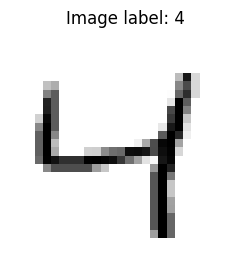

In [135]:
# Find the index of the first occurrence of the label '4' in the training dataset
index_of_four = (y_train == 4).nonzero()[0][0]
plot_mnist(x_train_flattened, index_of_four, label=4)
plt.show()


### Preprocessing: 
 * During this step, we will do some normalization on both the training and testing dataset.

In [136]:
# Extract and convert the pixel as numpy array with dtype='float32'
train = np.asarray(digits_train.iloc[:, 1:], dtype='float32') # Physical input
test = np.asarray(digits_test, dtype='float32') # Physical input
digital_train = np.asarray(x_train_flattened, dtype='float32') # Mathematically input
digital_test = np.asarray(x_test_flattened, dtype='float32') # Mathematically input

train_target = np.asarray(digits_train.loc[:, 'label'], dtype='int32') # Physical input label
digital_train_target = y_train # Mathematically input label
# print(train_target.shape, digital_train_target.shape)

In [137]:
# Scale the data
scaler = preprocessing.StandardScaler()
train_scale = scaler.fit_transform(train) # Xp for physical input trainng dataset 
test_scale = scaler.transform(test) # Xp for physical input testing dataset
digital_train_scale = scaler.fit_transform(digital_train) # Xd for mathematically input training dataset
digital_test_scale = scaler.transform(digital_test) # Xd for mathematically input testing dataset

## Implementation using Numpy

### The Logistic Regression

In this section, we will implement a logistic regression model trainable with Stochastic Gradient Descent (SGD) using `Numpy`. Here are the objectives:
* Implement a simple forward model with no hidden layer (equivalent to logisitic regression).
* Build a predict function which returns the most probable class given an input $x$.
* Build an accuracy function for a batch of inputs $X$ and the corresponding expected output $y_{true}$.
* Build a gradient function which computes the derivative of $-\log(softmax(Wx + b))$ with respect to $W$ for an $x$ and its corresponding expected output $y_{true}$.
* Build a train function which uses the gradient function out to update $\mathbf{W}$ and $b$.

**One-hot encoding for class label data**

First, let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to Keras `to_categorical` or sklearn `OneHotEncoder`).

In [138]:
def one_hot(n_classes, y):
    """Encode categorical integer as a one-hot numerical array.
    
    Parameters
    ----------
    n_classes: integer
        The number of class considered
    y: integer array
        The integers that represent a category
    
    Return
    ------
    An array containing the one-hot encoding of the categorical
    array.
    
    Examples
    --------
    >>>one_hot(n_classes=10, y=3)
    array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
    
    >>>one_hot(n_classes=10, y=[3, 0, 6])
    array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
           [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
           [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])
    """
    return np.eye(n_classes)[y]

**The softmax function**

Now, let's implement the softmax vector function:

$$softmax(\mathbf{x}) = \frac{1}{\sum \exp(x_i)}\begin{pmatrix}\exp(x_1) & \exp(x_2) & \dots & \exp(x_n)\end{pmatrix}^\top.$$

In fact, we will substract $\max{x}$ to each $x_i$ for implementation and more robust and stable computation.

In [139]:
def softmax(X):
    """ Compute the softmax function of a vector.
    
    Parameters
    ----------
    X: array
        Input values
    
    Return
    ------
    An array containing the softmax values. For each row, the
    sum of the column should be one.
    
    Examples
    --------
    >>>softmax([10, 2, -3])
    array([9.99662391e-01, 3.35349373e-04, 2.25956630e-06])
    >>>softmax([[10, 2, -3],
                [-1, 5, -20]])
    array([[9.99662391e-01, 3.35349373e-04, 2.25956630e-06],
       [2.47262316e-03, 9.97527377e-01, 1.38536042e-11]])
    """
    X = np.atleast_2d(X)
    
    exp = np.exp(X - np.max(X, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=-1, keepdims=True)

In [140]:
# Test of the softmax function
print(f"Softmax of a single vector: {softmax([10, 2, -3])}.")

Softmax of a single vector: [[9.99662391e-01 3.35349373e-04 2.25956630e-06]].


In [141]:
# Check that the probabilities sum to one
print(f"Sum of a softmax vector: {np.sum(softmax([10, 2, -3]))}")

Sum of a softmax vector: 1.0


In [142]:
# Test of the softmax function of two vectors
print(f"Softmax of two vectors: {softmax([[10, 2, -3], [-1, 5, -20]])}.")

Softmax of two vectors: [[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]].


In [143]:
# Check that the probabilities sum to one
print(f"Sum of a softmax vector: {np.sum(softmax([[10, 2, -3], [-1, 5, -20]]), axis=1)}")

Sum of a softmax vector: [1. 1.]


**The negative log-likelihood**

Then, we implement a function that given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred` returns the negative log-likelihood.

In [144]:
def neg_log_likelihood(Y_true, Y_pred):
    """Compute the negative log-likelihood of a sample.
    
    Parameters
    ----------
    Y_true: array
        One-hot encoded class
    Y_pred: array
        Predicted probabilities
    
    Return
    ------
    The average negative log-likelihood of the sample. The closest we are
    to 0, the better are the predictions.
    
    Examples
    --------
    >>>neg_log_likelihood([1, 0, 0], [0.99, 0, 0.01])
    array([0.01005034])
    >>>neg_log_likelihood([1, 0, 0], [0.01, 0.98, 0.01])
    array([4.60517019])
    >>>Y_true = np.array([[0, 1, 0],
                          [1, 0, 0],
                          [0, 0, 1]])
    >>>Y_pred = np.array([[0,   1,    0],
                          [.99, 0.01, 0],
                          [0,   0,    1]])
    >>>neg_log_likelihood(Y_true, Y_pred)
    0.00335011195116715
    """
    Y_true = np.atleast_2d(Y_true)
    Y_pred = np.atleast_2d(Y_pred)
    
    loglike = np.sum(np.log(1e-8 + Y_pred) * Y_true, axis=1)
    return -np.mean(loglike)

In [145]:
# Make sure that it works for a simple sample at a time
print(f"Negative log-likelihood : {neg_log_likelihood([1, 0, 0], [.99, 0.01, 0])}.")

Negative log-likelihood : 0.01005032575249135.


In [146]:
# Check that the negative log-likelihood of a very confident yet bad
# prediction is a much higher positive number
print(f"Negative log-likelihood : {neg_log_likelihood([1, 0, 0], [0.01, 0.01, .98])}.")

Negative log-likelihood : 4.605169185988592.


In [147]:
# Check that the average negative log-likelihood of the following three
# almost perfect predictions is close to 0
Y_true = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]])
Y_pred = np.array([[0, 1, 0], [.99, 0.01, 0], [0, 0, 1]])

print(f"Negative log-likelihood : {neg_log_likelihood(Y_true, Y_pred)}.")

Negative log-likelihood : 0.0033501019174971905.


In [148]:
# Split the train set into train and validation set.
# We will use 15% of the data for validation
# for physical input dataset
X_train, X_val, y_train, y_val = train_test_split(
    train_scale, train_target, test_size=0.15, random_state=42)
# for mathematically input dataset
Xd_train, Xd_val, yd_train, yd_val = train_test_split(
    digital_train_scale, digital_train_target, test_size=0.15, random_state=42)


### The Feedforward Multilayer

The objective of this section is to implement the backpropagation algorithm (SGD with the chain rule) on a single layer neural network using the sigmoid activation function.

**The sigmoid function**

The sigmoid function is defined by:
$$S(x) = \frac{1}{1 + \exp(-x)} = \frac{\exp(x)}{\exp(x) + 1}$$

The derivative of the sigmoid function is defined by:
$$\frac{dS(x)}{dx} = S(x)\left(1 - S(x)\right)$$

In [149]:
# Definition of the sigmoid function.
def sigmoid(X):
    """Compute the sigmoid function.
    
    Parameter
    ---------
    X: array-like
        Input array
        
    Return
    ------
    Sigmoid function on the input array.
    
    Examples
    --------
    >>>sigmoid(np.array([5, 2, 0]))
    array([0.99330715, 0.88079708, 0.5])
    >>>sigmoid(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[0.99330715, 0.88079708, 0.5],
           [0.11920292, 0.95257413, 0.5]])
           
    Notes
    -----
    X < -709 is to prevent exp overflow.
    """
    X[X < -709] = -709
    return 1 / (1 + np.exp(-X))

def dsigmoid(X):
    """Compute the element-wide derivative of the sigmoid function.
    
    Parameter
    ---------
    X: array-like
        Input array
    
    Return
    ------
    Derivative of the sigmoid function on the input array.
    
    Examples
    --------
    >>>dsigmoid(np.array([5, 2, 0]))
    array([0.00664806, 0.10499359, 0.25])
    >>>dsigmoid(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[0.00664806, 0.10499359, 0.25],
           [0.10499359, 0.04517666, 0.25]])
    """
    S = sigmoid(X)
    return S * (1 - S)

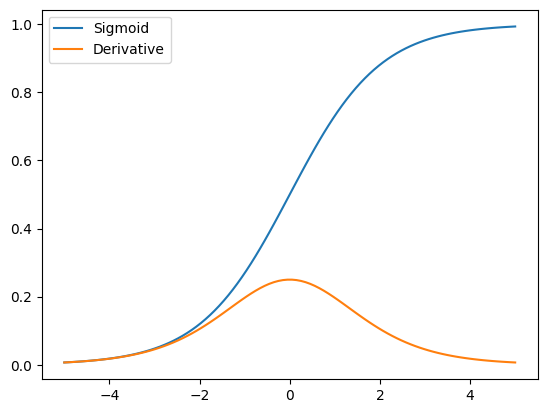

In [150]:
# Plot of the functions
X = np.linspace(-5, 5, 100)
plt.plot(X, sigmoid(X), label='Sigmoid')
plt.plot(X, dsigmoid(X), label='Derivative')
plt.legend(loc='best')
plt.show()

**The tanh function**

The tanh function is defined by:
$$T(x) = \frac{\exp(2x) - 1}{\exp(2x) + 1}$$

The derivative of the tanh function is defined by:
$$\frac{dT(x)}{dx} = 1 - T(x)^2$$

In [151]:
# Definition of the tanh function.
def tanh(X):
    """Compute the tanh function.
    
    Parameter
    ---------
    X: array-like
        Input array
        
    Return
    ------
    Tanh function on the input array.
    
    Examples
    --------
    >>>tanh(np.array([5, 2, 0]))
    array([0.9999092 , 0.96402758, 0.])
    >>>tanh(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[ 0.9999092 ,  0.96402758,  0.],
           [-0.96402758,  0.99505475,  0.]])
    
    Notes
    -----
    X > 354 is to prevent exp overflow.
    """
    X[X > 354] = 354
    exp = np.exp(2*X)
    return (exp - 1) / (exp + 1)

def dtanh(X):
    """Compute the element-wide derivative of the tanh function.
    
    Parameter
    ---------
    X: array-like
        Input array
    
    Return
    ------
    Derivative of the tanh function on the input array.
    
    Examples
    --------
    >>>dtanh(np.array([5, 2, 0]))
    array([1.81583231e-04, 7.06508249e-02, 1.00000000e+00])
    >>>dtanh(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[1.81583231e-04, 7.06508249e-02, 1.00000000e+00],
           [7.06508249e-02, 9.86603717e-03, 1.00000000e+00]])
    """
    S = tanh(X)
    return 1 - np.power(S, 2)

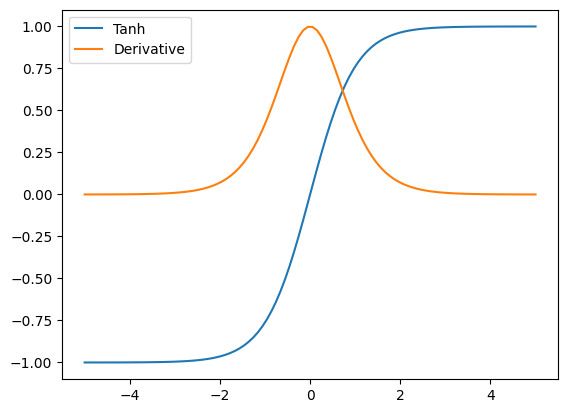

In [152]:
# Plot of the functions
X = np.linspace(-5, 5, 100)
plt.plot(X, tanh(X), label='Tanh')
plt.plot(X, dtanh(X), label='Derivative')
plt.legend(loc='best')
plt.show()

**The relu function**

The relu function is defined by:
$$R(x) = \max(0, x)$$

The derivative of the relu function is defined by:
$$\frac{dR(x)}{dx} = \mathbb{1}(x > 0)$$

In [153]:
# Definition of the relu function.
def relu(X):
    """Compute the relu function.
    
    Parameter
    ---------
    X: array-like
        Input array
        
    Return
    ------
    Relu function on the input array.
    
    Examples
    --------
    >>>relu(np.array([5, -2, 0]))
    array([5, 0, 0])
    >>>relu(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[5, 2, 0],
           [0, 3, 0]])
    """
    return np.maximum(0, X).astype(np.float64)

def drelu(X):
    """Compute the element-wide derivative of the relu function.
    
    Parameter
    ---------
    X: array-like
        Input array
    
    Return
    ------
    Derivative of the relu function on the input array.
    
    Examples
    --------
    >>>drelu(np.array([5, -2, 0]))
    array([1., 0., 0.])
    >>>drelu(np.array([[5, 2, 0], [-2, 3, 0]]))
    array([[1., 1., 0.],
           [0., 1., 0.]])
    """
    return np.array(X > 0).astype(np.float64)

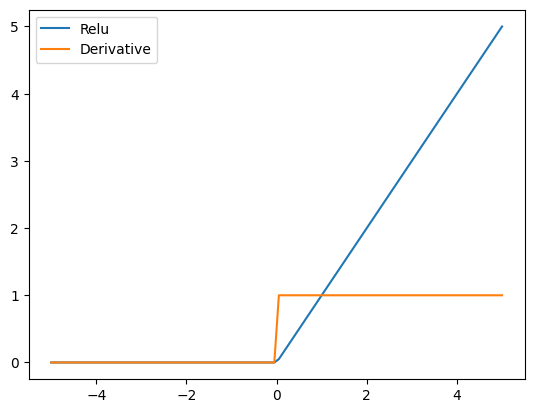

In [154]:
# Plot of the functions
X = np.linspace(-5, 5, 100)
plt.plot(X, relu(X), label='Relu')
plt.plot(X, drelu(X), label='Derivative')
plt.legend(loc='best')
plt.show()

In [155]:
class NeuralNetAT:
    def __init__(self, input_size, hidden_size, output_size, activation_function='sigmoid'):
        self.W_h = np.random.uniform(size=(input_size, hidden_size), low=-0.1, high=0.1)
        self.b_h = np.zeros(hidden_size)
        self.W_o = np.random.uniform(size=(hidden_size, output_size), low=-0.1, high=0.1)
        self.b_o = np.zeros(output_size)

        # Parallel model weights and biases (digital model)
        self.W_h_parallel = np.copy(self.W_h) # Hideen layer weights
        self.b_h_parallel = np.copy(self.b_h) # Hidden layer bias
        self.W_o_parallel = np.copy(self.W_o) # Output layer weights
        self.b_o_parallel = np.copy(self.b_o) # Output layer bias
        
        self.output_size = output_size
        self.activation_function = activation_function

    def forward_physical(self, X):
        """Compute the posterior probabilities with physical model errors."""
        # Error factor: standard normal distribution (mean=0, std=1)
        error_factor_W_h = np.random.normal(loc=0, scale=1, size=self.W_h.shape)
        error_factor_W_o = np.random.normal(loc=0, scale=1, size=self.W_o.shape)
        error_factor_b_h = np.random.normal(loc=0, scale=1, size=self.b_h.shape)
        error_factor_b_o = np.random.normal(loc=0, scale=1, size=self.b_o.shape)

        # Adjust weights with 30% systematic error
        W_h = self.W_h * (1 + 0.3 * error_factor_W_h)
        W_o = self.W_o * (1 + 0.3 * error_factor_W_o)
        b_h = self.b_h * (1 + 0.3 * error_factor_b_h)
        b_o = self.b_o * (1 + 0.3 * error_factor_b_o)

        z_h = np.dot(X, W_h) + b_h
        h = self._apply_activation(z_h)
        y = softmax(np.dot(h, W_o) + b_o)
        return y 
    
    def forward(self, X):
        """Compute the posterior probabilities."""
        z_h = np.dot(X, self.W_h) + self.b_h
        h = self._apply_activation(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y

    def forward_keep_activations_physical(self, X):
        """Compute the posterior probabilities with physical model errors, keeping activations."""
        # Error factor: standard normal distribution (mean=0, std=1)
        error_factor_W_h = np.random.normal(loc=0, scale=1, size=self.W_h.shape)
        error_factor_W_o = np.random.normal(loc=0, scale=1, size=self.W_o.shape)
        error_factor_b_h = np.random.normal(loc=0, scale=1, size=self.b_h.shape)
        error_factor_b_o = np.random.normal(loc=0, scale=1, size=self.b_o.shape)

        # Adjust weights with 30% systematic error
        W_h = self.W_h * (1 + 0.3 * error_factor_W_h)
        W_o = self.W_o * (1 + 0.3 * error_factor_W_o)
        b_h = self.b_h * (1 + 0.3 * error_factor_b_h)
        b_o = self.b_o * (1 + 0.3 * error_factor_b_o)

        z_h = np.dot(X, W_h) + b_h
        h = self._apply_activation(z_h)
        y = softmax(np.dot(h, W_o) + b_o)
        return y, h, z_h
    
    def forward_keep_activations(self, X):
        """Compute the posterior probabilities, keeping activations."""
        z_h = np.dot(X, self.W_h) + self.b_h
        h = self._apply_activation(z_h)
        y = softmax(np.dot(h, self.W_o) + self.b_o)
        return y, h, z_h

    def grad_loss_physical(self, X, y_true):
        """Backpropagation of the gradients for the physical model."""
        y_pred, h, z_h = self.forward_keep_activations_physical(X)
        grad_z_o = y_pred - one_hot(self.output_size, y_true)
        
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * self._apply_activation_derivative(z_h)
        
        grad_W_h = np.outer(X, grad_z_h)
        grad_b_h = grad_z_h
        
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}
    
    def grad_loss(self, X, y_true):
        """Backpropagation of the gradients for the digital model."""
        y_pred, h, z_h = self.forward_keep_activations(X)
        grad_z_o = y_pred - one_hot(self.output_size, y_true)
        
        grad_W_o = np.outer(h, grad_z_o)
        grad_b_o = grad_z_o
        
        grad_h = np.dot(grad_z_o, np.transpose(self.W_o))
        grad_z_h = grad_h * self._apply_activation_derivative(z_h)
        
        grad_W_h = np.outer(X, grad_z_h)
        grad_b_h = grad_z_h
        
        return {"W_h": grad_W_h, "b_h": grad_b_h, "W_o": grad_W_o, "b_o": grad_b_o}
    
    def ATtrain(self, Xp, Yp, Xd, Yd, learning_rate, Mw1, Mw2):
        """Perform traditional SGD update without momentum."""
        # Physical model
        grads_p = self.grad_loss_physical(Xp, Yp)
        # Digital mathematical model
        grads_d = self.grad_loss(Xd, Yd)

        # Reshape the gradient biases to ensure they match the bias vector shape
        grad_b_h_p = np.squeeze(grads_p['b_h'])
        grad_b_h_d = np.squeeze(grads_d['b_h'])
        grad_b_o_p = np.squeeze(grads_p['b_o'])
        grad_b_o_d = np.squeeze(grads_d['b_o'])

        # Update the weights and biases for the physical model
        self.W_h -= learning_rate * (Mw1 * grads_d['W_h'] + Mw2 * grads_p['W_h'])
        self.b_h -= learning_rate * (Mw1 * grad_b_h_d + Mw2 * grad_b_h_p)

        self.W_o -= learning_rate * (Mw1 * grads_d['W_o'] + Mw2 * grads_p['W_o'])
        self.b_o -= learning_rate * (Mw1 * grad_b_o_d + Mw2 * grad_b_o_p)

        # Update the weights and biases for the digital model
        self.W_h_parallel -= learning_rate * grads_d['W_h']
        self.b_h_parallel -= learning_rate * grad_b_h_d

        self.W_o_parallel -= learning_rate * grads_d['W_o']
        self.b_o_parallel -= learning_rate * grad_b_o_d

    
    def predict(self, X):
        """Give the most probable class of the observations."""
        return np.argmax(self.forward(X), axis=1)

    def loss(self, X, y):
        """Compute the negative log-likelihood of the data."""
        return neg_log_likelihood(one_hot(self.output_size, y), self.forward(X))
    
    def accuracy(self, X, y):
        """Compute the prediction accuracy of the data."""
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

    def _apply_activation(self, z):
        """Helper function to apply activation function."""
        if self.activation_function == 'tanh':
            return tanh(z)
        elif self.activation_function == 'relu':
            return relu(z)
        else:
            return sigmoid(z)

    def _apply_activation_derivative(self, z):
        """Helper function to apply derivative of activation function."""
        if self.activation_function == 'tanh':
            return dtanh(z)
        elif self.activation_function == 'relu':
            return drelu(z)
        else:
            return dsigmoid(z)


**The feedforward neural network with one hidden layer**

In [156]:
# Build a NeuralNet model and test its forward inference
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = 10
model = NeuralNetAT(n_features, n_hidden, n_classes)

print(f"""Evaluation of the untrained model (recall that the weights are initialized as random):
    * train loss: {model.loss(X_train, y_train)}
    * train accuracy: {model.accuracy(X_train, y_train)}
    * test accuracy: {model.accuracy(X_val, y_val)}
    """)

Evaluation of the untrained model (recall that the weights are initialized as random):
    * train loss: 2.301498352442929
    * train accuracy: 0.056862745098039215
    * test accuracy: 0.057301587301587305
    


In [157]:

# Assuming X_train, y_train, X_val, y_val, Xd_train, and yd_train are already defined and preprocessed
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))
n_hidden = 10
EPOCHS = 15
learning_rate = 0.1

# Define different mixing ratios to test
mixing_ratios = [(0.1, 0.9),(0.3, 0.7),(0.5, 0.5),(0.7, 0.3),(0.9, 0.1)]

# Initialize dictionaries to store losses and test accuracies for different mixing ratios
losses_by_mixing_ratio = {}
test_accuracies_by_mixing_ratio = {}

# Loop over each mixing ratio and evaluate the model
for Mw1, Mw2 in mixing_ratios:
    # Initialize the NeuralNetAT model
    model = NeuralNetAT(n_features, n_hidden, n_classes)
    
    # Lists to store loss and accuracies for each epoch
    losses = [model.loss(X_train, y_train)]
    accuracies = [model.accuracy(X_train, y_train)]
    accuracies_val = [model.accuracy(X_val, y_val)]
    
    # Training the model for a number of epochs
    for epoch in range(EPOCHS):
        for i, (x_p, y_p, x_d, y_d) in enumerate(zip(X_train, y_train, Xd_train, yd_train)):
            # Train the model with the ATtrain method and specified mixing ratios
            model.ATtrain(x_p, y_p, x_d, y_d, learning_rate, Mw1, Mw2)
        
        # Calculate and store the loss and accuracy after each epoch
        losses.append(model.loss(X_train, y_train))
        accuracies.append(model.accuracy(X_train, y_train))
        accuracies_val.append(model.accuracy(X_val, y_val))

        # Print the results for the current epoch
        print(f"Mixing Ratios Mw1={Mw1}, Mw2={Mw2}, Epoch #{epoch+1}: train loss: {losses[-1]:.4f}, train accuracy: {accuracies[-1]:.4f}, test accuracy: {accuracies_val[-1]:.4f}")
    
    # Store the losses and test accuracies for this mixing ratio
    losses_by_mixing_ratio[(Mw1, Mw2)] = losses
    test_accuracies_by_mixing_ratio[(Mw1, Mw2)] = accuracies_val


Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #1: train loss: 0.5419, train accuracy: 0.8537, test accuracy: 0.8438
Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #2: train loss: 0.5649, train accuracy: 0.8635, test accuracy: 0.8470
Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #3: train loss: 0.5398, train accuracy: 0.8743, test accuracy: 0.8643
Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #4: train loss: 0.5789, train accuracy: 0.8713, test accuracy: 0.8703
Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #5: train loss: 0.5791, train accuracy: 0.8791, test accuracy: 0.8729
Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #6: train loss: 0.5889, train accuracy: 0.8757, test accuracy: 0.8663
Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #7: train loss: 0.6187, train accuracy: 0.8818, test accuracy: 0.8724
Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #8: train loss: 0.6160, train accuracy: 0.8845, test accuracy: 0.8786
Mixing Ratios Mw1=0.1, Mw2=0.9, Epoch #9: train loss: 0.6984, train accuracy: 0.8702, test accuracy: 0.8665
Mixing Ratios Mw1=0.1, Mw2=0

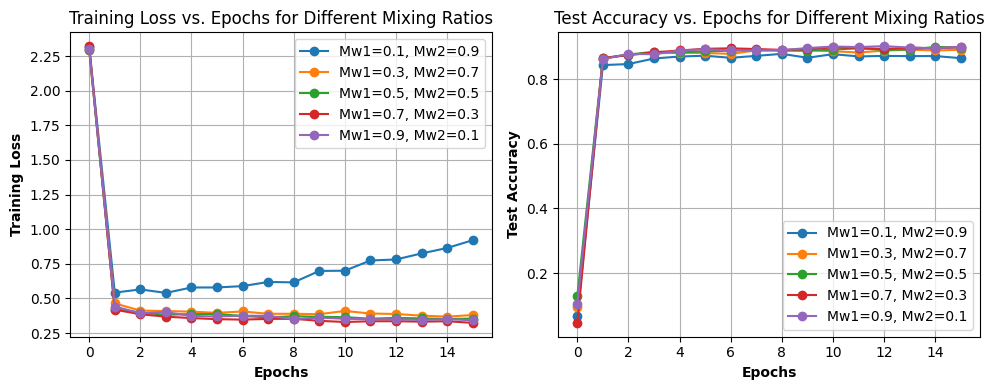

In [171]:

# Optionally, plot the results
plt.figure(figsize=(10, 4))

# Plotting losses for different mixing ratios
plt.subplot(1, 2, 1)
for (Mw1, Mw2), losses in losses_by_mixing_ratio.items():
    plt.plot(range(EPOCHS + 1), losses, marker='o', label=f'Mw1={Mw1}, Mw2={Mw2}')
plt.title('Training Loss vs. Epochs for Different Mixing Ratios', fontsize=12)
plt.xlabel('Epochs', fontsize=10, fontweight='bold')
plt.ylabel('Training Loss', fontsize=10, fontweight='bold')
plt.legend()
plt.grid(True)

# Plotting test accuracies for different mixing ratios
plt.subplot(1, 2, 2)
for (Mw1, Mw2), accuracies_val in test_accuracies_by_mixing_ratio.items():
    plt.plot(range(EPOCHS + 1), accuracies_val, marker='o', label=f'Mw1={Mw1}, Mw2={Mw2}')
plt.title('Test Accuracy vs. Epochs for Different Mixing Ratios', fontsize=12)
plt.xlabel('Epochs', fontsize=10, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=10, fontweight='bold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


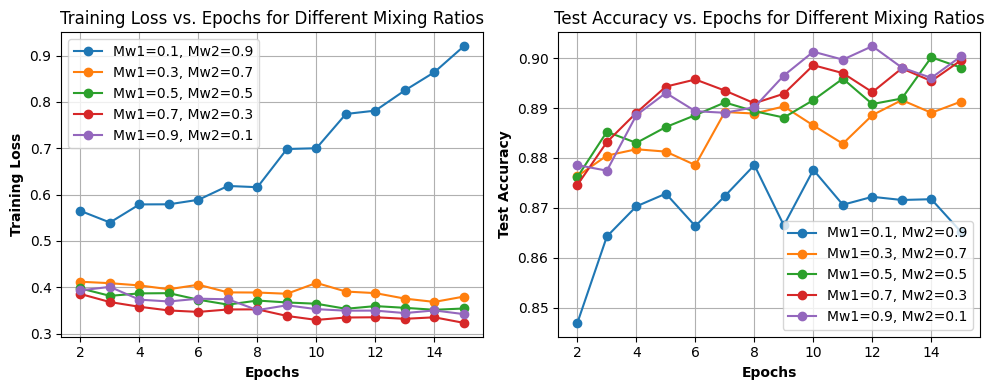

In [173]:
# Optionally, plot the results
plt.figure(figsize=(10, 4))

# Plotting losses for different mixing ratios
plt.subplot(1, 2, 1)
for (Mw1, Mw2), losses in losses_by_mixing_ratio.items():
    plt.plot(range(2, EPOCHS + 1), losses[2:], marker='o', label=f'Mw1={Mw1}, Mw2={Mw2}')
plt.title('Training Loss vs. Epochs for Different Mixing Ratios', fontsize=12)
plt.xlabel('Epochs', fontsize=10, fontweight='bold')
plt.ylabel('Training Loss', fontsize=10, fontweight='bold')
plt.legend()
plt.grid(True)

# Plotting test accuracies for different mixing ratios
plt.subplot(1, 2, 2)
for (Mw1, Mw2), accuracies_val in test_accuracies_by_mixing_ratio.items():
    plt.plot(range(2, EPOCHS + 1), accuracies_val[2:], marker='o', label=f'Mw1={Mw1}, Mw2={Mw2}')
plt.title('Test Accuracy vs. Epochs for Different Mixing Ratios', fontsize=12)
plt.xlabel('Epochs', fontsize=10, fontweight='bold')
plt.ylabel('Test Accuracy', fontsize=10, fontweight='bold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
